# GEO-AI Challenge for Cropland Mapping by ITU
_Antoine Saget_

In this notebook, the solution for the Zindi GEO-AI Challenge for Cropland Mapping by ITU to achieve a 0.943 acc on the private leaderboard.

We also provide a second notebook / python script (simple_reproduction.ipynb / simple_reproduction.py ) with much simpler code that reproduce the same results. 
This other notebook will probably be easier to integrate in your own workflow as it doesn't rely on any additional file and classes.

Section 1.-4. are dependant and must be runned one after the other, Section 5. is independant and can be run without the others.
Yo can skip to 5. to reproduce the private leaderboard solutions or start from 1. to get a better understanding of the data download and prepprocessing steps.

Notebook table of contents:
1. Downloading the data from GEE
2. Data preprocessing
3. Study on the impact of timerange
4. Study on the impact of Sentinel-2 radiometric bands
5. Best model

In [18]:
# Imports and seeds initializations
import ee
# import folium
# import random
# import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from tabulate import tabulate
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.cluster import KMeans
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split, KFold
# from sklearn.metrics import accuracy_score

# from tqdm import tqdm

from utils import filter_by_country, interpolate_ts
from dataset import Dataset, Dataset_training_ready
from constants import SUDAN, AFGHANISTAN, IRAN, COUNTRY_NAME, START_DATE, END_DATE, BOUNDS, TARGET, B2, B3, B4, B8, LON, LAT, NDVI, SCL, PROJECT_NAME, ID, IS_TRAIN, COUNTRY, ALL_BANDS
from model import Model, rf_builder, rf_builder_shallow, rf_builder_big

# Set seed for reproducibility
SEED = 2023
# random.seed(SEED)
# np.random.seed(SEED)

In [19]:
# Country bounds and timeranges
country_settings = {
   SUDAN: {
        COUNTRY_NAME: SUDAN,
        START_DATE: '2019-07-01',
        END_DATE: '2020-06-30',
        BOUNDS: [[14.1, 33.1], [14.6, 33.6]]
    },
    AFGHANISTAN: {
        COUNTRY_NAME: AFGHANISTAN,
        START_DATE: '2022-04-01',
        END_DATE: '2022-04-30',
        BOUNDS: [[34.0, 70.2], [34.4, 70.8]]
    },
    IRAN: {
        COUNTRY_NAME: IRAN,
        START_DATE: '2019-07-01',
        END_DATE: '2020-06-30',
        BOUNDS: [[32.0, 48.1], [32.5, 48.6]]
    }
}

# 1. Downloading the data from GEE

In this part, timeserie data from Sentinel-2 is downloaded from GEE.

When cloning the git repo, the data is already pre-dowloaded in the data folder.
If you want to download it from scratch, remove files in the data folder and run the following cells.
Redownloading the data from scratch can take up to 1h30~.

Please note that both options output the exact same data as of 06/10/2023 as the pre-dowloaded data is just a collection of .csv files saved from the data obtained with GEE. However, with possible future changes to the GEE Sentinel-2 collection, the pre-downloaded data might get outdated.

In [3]:
# This cell is only necessary if you want to redownload the data from scratch
# If data is already pre-downloaded in data/, you can skip this it

# Authenticate and initialize Earth Engine
# ee.Authenticate()
ee.Initialize()

##### PLEASE SET THIS VARIABLE TO YOUR PROJECT NAME IN GEE #####
PROJECT_NAME = "ee-antoinesaget"

In [4]:
from dataset import Dataset

ds = Dataset.from_files('Train.csv', 'Test.csv', 'Full dataset', country_settings, debug_level=1)
ds.load_all_optical_data(PROJECT_NAME)

########################################
Dataset info:
    Name : Full dataset
    Train shape: (1500, 6)
    Test shape: (1500, 6)
    TrainTest shape: (3000, 6)
    Center : [24.21, 51.94]
    Bounds :
        min : [14.10, 33.10]
        max : [34.31, 70.78]
    Train head:


/home/antoine/zindi/geo_ai_cropland_mapping_submission/dataset.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sudan' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[mask, COUNTRY] = country[COUNTRY_NAME]


,ID,Lat,Lon,Target,IsTrain,Country
0,ID_SJ098E7S2SY9,34.162491,70.763668,0.0,True,Afghanistan
1,ID_CWCD60FGJJYY,32.075695,48.492047,0.0,True,Iran
2,ID_R1XF70RMVGL3,14.542826,33.313483,1.0,True,Sudan
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1.0,True,Sudan
4,ID_C20R2C0AYIT0,14.419128,33.528450,0.0,True,Sudan


    Test head:


,ID,Lat,Lon,Target,IsTrain,Country
0,ID_9ZLHTVF6NSU7,34.254835,70.348699,NaN,False,Afghanistan
1,ID_LNN7BFCVEZKA,32.009669,48.535526,NaN,False,Iran
2,ID_SOYSG7W04UH3,14.431884,33.399991,NaN,False,Sudan
3,ID_EAP7EXXV8ZDE,14.281866,33.441224,NaN,False,Sudan
4,ID_QPRX1TUQVGHU,14.399365,33.109566,NaN,False,Sudan


########################################
Country Sudan info:
    Start date: 2019-07-01
    End date: 2020-06-30
    Train shape: (500, 6)
    Test shape: (500, 6)
Country Afghanistan info:
    Start date: 2022-04-01
    End date: 2022-04-30
    Train shape: (500, 6)
    Test shape: (500, 6)
Country Iran info:
    Start date: 2019-07-01
    End date: 2020-06-30
    Train shape: (500, 6)
    Test shape: (500, 6)


The timeserie data downloaded from GEE is as follow:

For each datapoint in the training and test sets, we dowload all timesteps from 1 year before and 1 year after the challenges given ranges with the following parameters:
- No cloud filtering, cloudy timesteps are kept
- Filter out of nan/null values
- All Sentinel-2 bands + SCL + NDVI
- 10m resolution

_Please see `downloader.py/_start_download_task()` function or `simple_reproduction.ipynb/start_download_task()` function for more details on the GEE task._

This will result in multivariate timeseries with a different number of timesteps and different starting and ending dates for each datapoint.
We illustrate this with histograms of number of timesteps below :

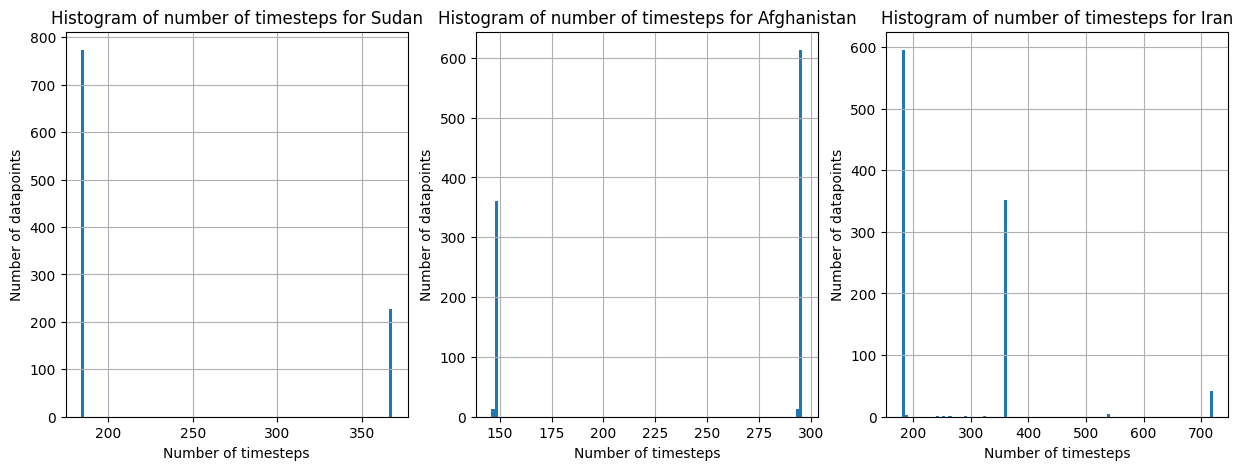

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for country, ax in zip(ds.countries, axs):
    mask = filter_by_country(ds._df, country)
    ids = ds._df[mask][ID]
    optical_country = ds._optical_df[ds._optical_df[ID].isin(ids)]
    optical_country.groupby(ID).count()[NDVI].hist(bins=100, ax=ax)

    ax.set_title(f'Histogram of number of timesteps for {country.name}')
    ax.set_xlabel('Number of timesteps')
    ax.set_ylabel('Number of datapoints')
plt.show()

As we can see, the number of timesteps varies a lot between datapoints : from 100 up to 700+ timesteps.  
This variation occurs even within the same country.

This is due to the fact that Sentinel-2 revisit time is not always 5 days due to tile overlaping and other factors.

Timeseries with different number of timesteps cannot be trivially fed to a supervised model like a Random Forest as the number of features will vary between datapoints.  
In the next section we show how we deal with this issue with a simple interpolation and reindexing method.

# 2. Data preprocessing

For our solution, the only data preprocessing we add after gathering the timeseries data from GEE is a simple interpolation and reindexing method to deal with the varying number of timesteps and alignement issues.

Further preprocessing such as cloud filtering, standaridzation or normalization might improve the results, especially for models not as robust to outliers as Random Forests or for models sensitive to scale such as Neural Networks.

However, in this notebook, no further preprocessing is done.

Reindexing and interpolation is done with the `utils.py/interpolate_ts()` function. Here is a simplified version of the function:

```python
# Please not this is a simplified version of the function that might not work as is
def interpolate_ts(df, start_date, end_date, sampling_rate):
    # A range of date from start_date to end_date with one timestep every day
    date_range = pd.date_range(start_date, end_date, freq='D', normalize=True)

    # Currently, each row is a timestep, a timeserie is a group of rows with the same ID
    groups = df.groupby(ID)

    # For each timeserie, we reindex the rows with the date_range
    # This will create rows with nan values for missing timesteps
    X = groups.apply(
        lambda x: x.set_index(TIMESTAMP)[bands].reindex(date_range).values
    )

    # Convert the timeseries to a 3D numpy array of shape (n_objects, n_timesteps, n_bands)
    X = np.stack(X.values).astype('float32')
    n_objects, n_timesteps, n_bands = X.shape
    
    # A mask of all nan timesteps
    isnan = np.isnan(X[:, :, 0])

    # For each timeserie
    for i, x in enumerate(X):
        valid_timesteps = np.arange(n_timesteps)[~isnan[i]]
        valid_values = X[i, valid_timesteps]

        # For each band
        for j in range(n_bands):
            
            # Perform linear interpolation and extrapolation
            # nan timesteps are replaced by interpolated values
            X[i, :, j] = np.interp(np.arange(n_timesteps), valid_timesteps, valid_values[:, j])
    
    # We only keep one timestep every sampling_rate
    # Considering that Sentinel-2 revisit time is 5 days
    # Sampling rate is 5 by default as there will be no additional information with a higher sampling rate
    X = X[:, ::sampling_rate, :]

    return X
```

This results in a 3D numpy array of shape (n_objects, n_timesteps, n_bands) that can be flattened to a 2D numpy array of shape (n_objects, n_timesteps * n_bands) and fed to any supervised model.

Below we show NDVI training timeseries for each country :

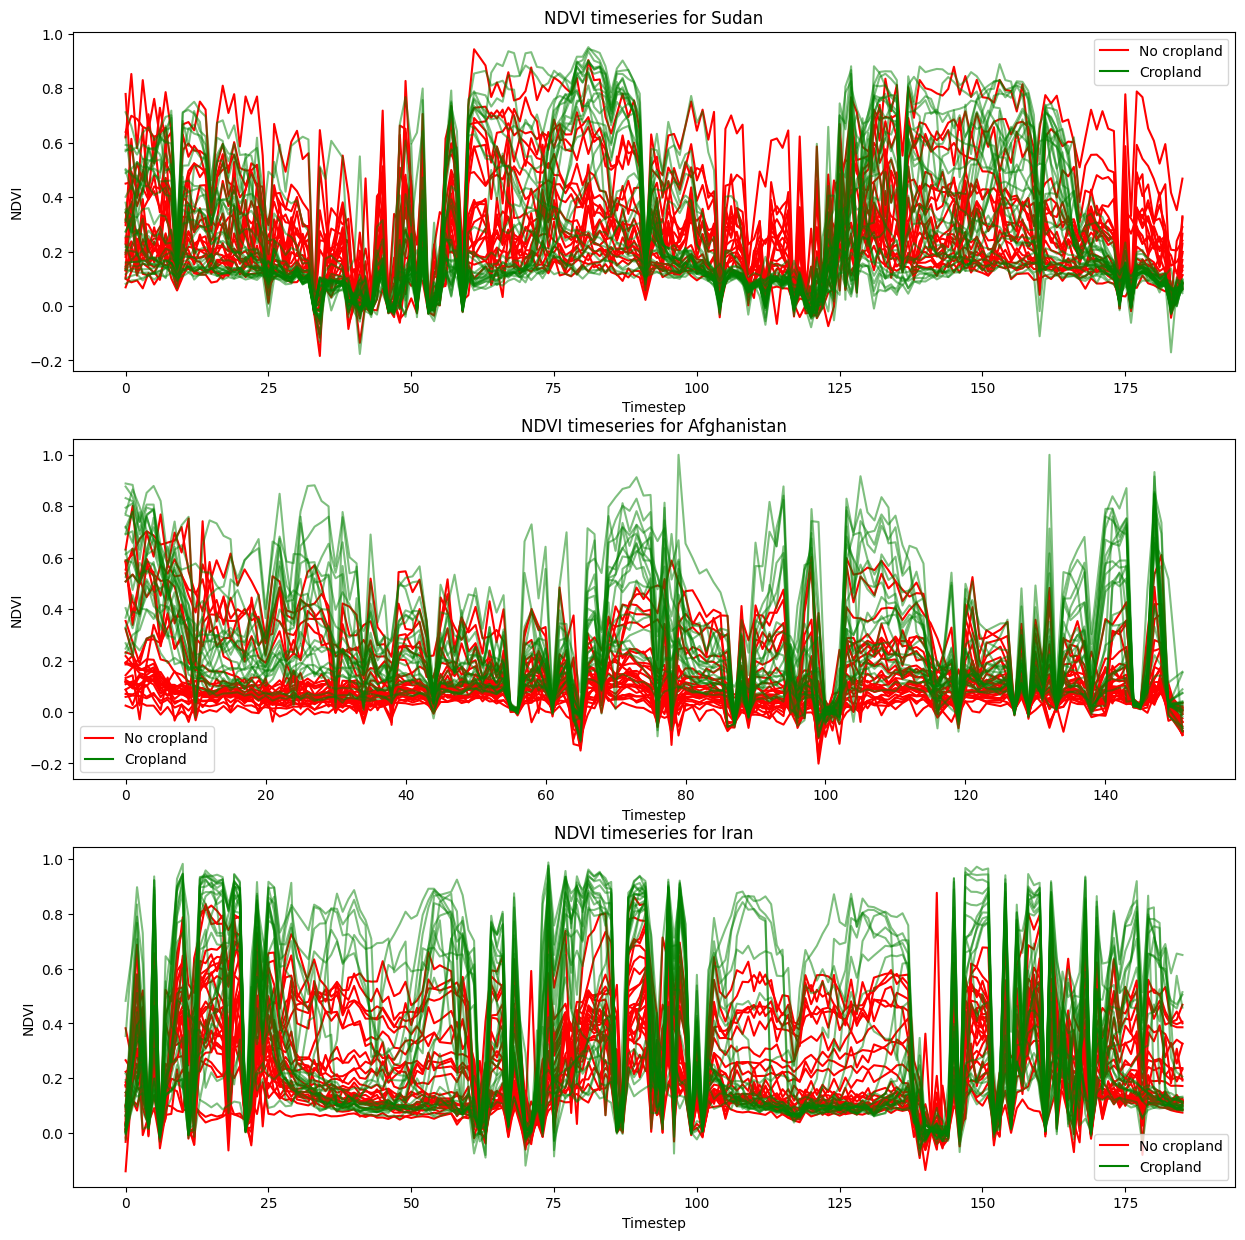

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

for country, ax in zip(ds.countries, axs):
    country_mask = filter_by_country(ds._df, country)
    ids = ds._df.loc[ds._df[IS_TRAIN] & country_mask, ID]
    optical_filtered = ds._optical_df.loc[ds._optical_df[ID].isin(ids)]
    X, IDs_ = interpolate_ts(optical_filtered, [NDVI])
    Y = ds._df.loc[ds._df[ID].isin(ids)].set_index(ID).loc[IDs_][TARGET].values

    X = X[:50]
    Y = Y[:50]

    ax.plot(X[Y == 0, :, 0].T, color='red', alpha=1)
    ax.plot(X[Y == 1, :, 0].T, color='green', alpha=0.5)

    # legend
    ax.plot([], [], color='red', label='No cropland')
    ax.plot([], [], color='green', label='Cropland')

    ax.set_title(f'NDVI timeseries for {country.name}')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('NDVI')
    ax.legend()

plt.show()

We can see that, despite being noisy, timeseries of class 1 in green (cropland) have different NDVI profiles than timeseries of class 0 in red (non-cropland). Being able to see visual difference between the two classes with a simple NDVI profile is a good sign.

We can see many spikes in the timeseries, these are mostly due to clouds and cloud shadows.
Futrher preprocessing to obtain a cleaner timeseries might be necessary for some models but is not done in this notebook as we use a Random Forest which is robust to unclean data.

# 3. Study on the impact of diffferent timerange

In this section we study the impact of the timeseries timerange and timeperiod on the model performance.
We train a RandomForest with the same parameters on different timeranges and timeperiods and compare the results.

More precisely, we investigate timeranges of 1 month, 3 months, 6 months, 1 year, and 2 years.  
We investigate timeperiods every 2 month strarting from 1 year before the given range to 1 year after the given range.

In [7]:
# Parameters
spans = ['4W', '12W', '24W', '48W', '96W']
spans_friendly_unit = ['1M', '3M', '6M', '1Y', '2Y']
freq = '2M'
bands = [B2, B3, B4, B8]

In [38]:
# Experiment
# ~3min on AMD 5900x CPU
# ~ on Google Colab
countries_accs = []
end_dates_in_experiment_countries = []
for country in country_settings.values():
    print(country[COUNTRY_NAME])

    true_start_date = pd.to_datetime(country[START_DATE]) - pd.Timedelta(days=365)
    true_end_date = pd.to_datetime(country[END_DATE]) + pd.Timedelta(days=365)

    end_dates = pd.date_range(
        start=true_start_date,
        end=true_end_date,
        freq=freq
    )

    accs_spans = []
    end_dates_in_experiment_spans = []
    for span, friendly_span in zip(spans, spans_friendly_unit):
        accs_end_dates = []
        end_dates_in_experiment = []
        # print(f'    Span : {span}')
        print(f'    Getting results for {friendly_span} timespan...')
        for end_date in end_dates:
            start_date = end_date - pd.Timedelta(span)
            if start_date < true_start_date:
                continue
            
            start_date = start_date.strftime('%Y-%m-%d')
            end_date_ = end_date.strftime('%Y-%m-%d')
            # print(f'        {start_date} - {end_date_} : ', end='')

            ds_ts = Dataset_training_ready.get_ts_data_from(
                ds, bands, PROJECT_NAME, country[COUNTRY_NAME], start_date, end_date_)

            if ds_ts._df_optical.shape[0] == 0:
                # print('No data found.')
                continue
            
            model = Model(rf_builder_shallow, ds_ts, SEED)
            acc, acc_0, acc_1, _, _ = model.train_with_cv_one_rf(debug_level=0, n_splits=2)
            # print(f'{acc:.2f}')
            accs_end_dates.append(acc)
            end_dates_in_experiment.append(end_date)
        accs_spans.append(accs_end_dates)
        end_dates_in_experiment_spans.append(end_dates_in_experiment)
    countries_accs.append(accs_spans)
    end_dates_in_experiment_countries.append(end_dates_in_experiment_spans)

Sudan
    Getting results for 1M timespan...
    Getting results for 3M timespan...
    Getting results for 6M timespan...
    Getting results for 1Y timespan...
    Getting results for 2Y timespan...
Afghanistan
    Getting results for 1M timespan...
    Getting results for 3M timespan...
    Getting results for 6M timespan...
    Getting results for 1Y timespan...
    Getting results for 2Y timespan...
Iran
    Getting results for 1M timespan...
    Getting results for 3M timespan...
    Getting results for 6M timespan...
    Getting results for 1Y timespan...
    Getting results for 2Y timespan...


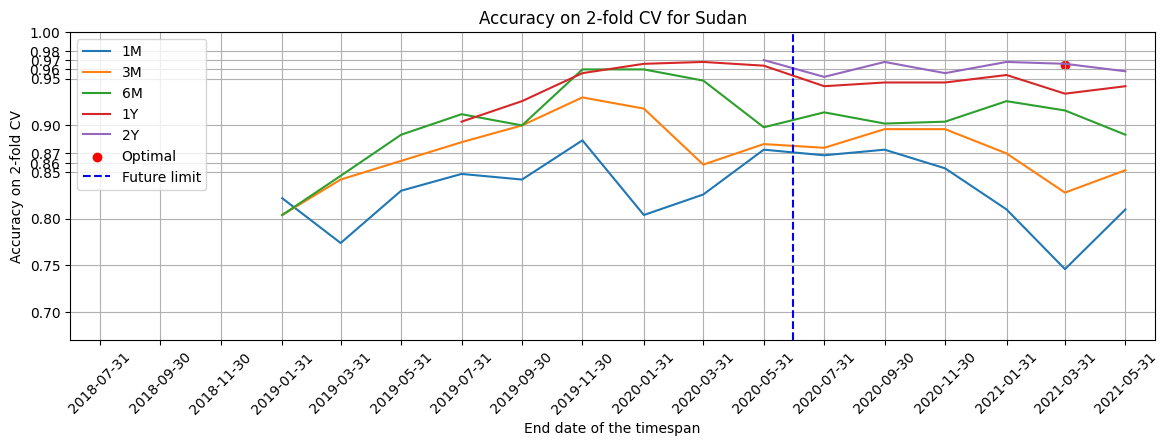

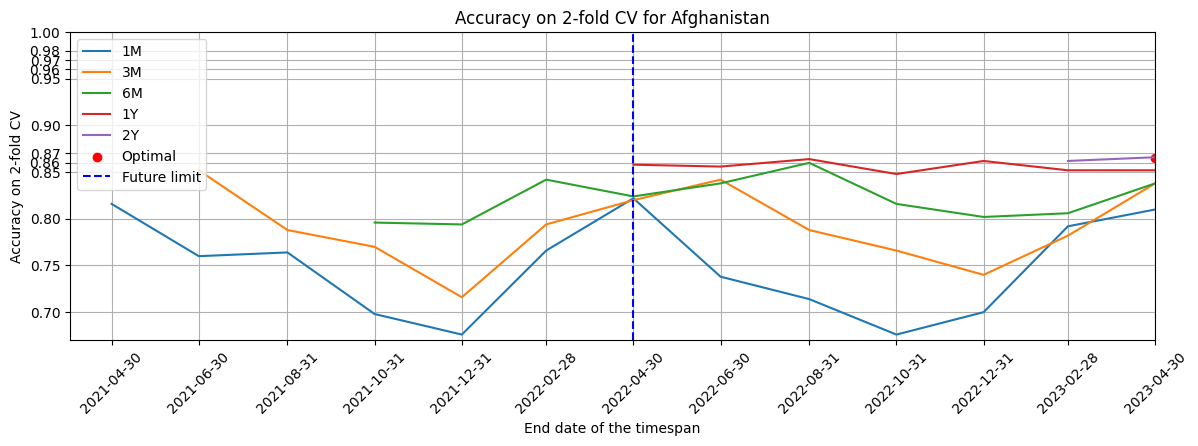

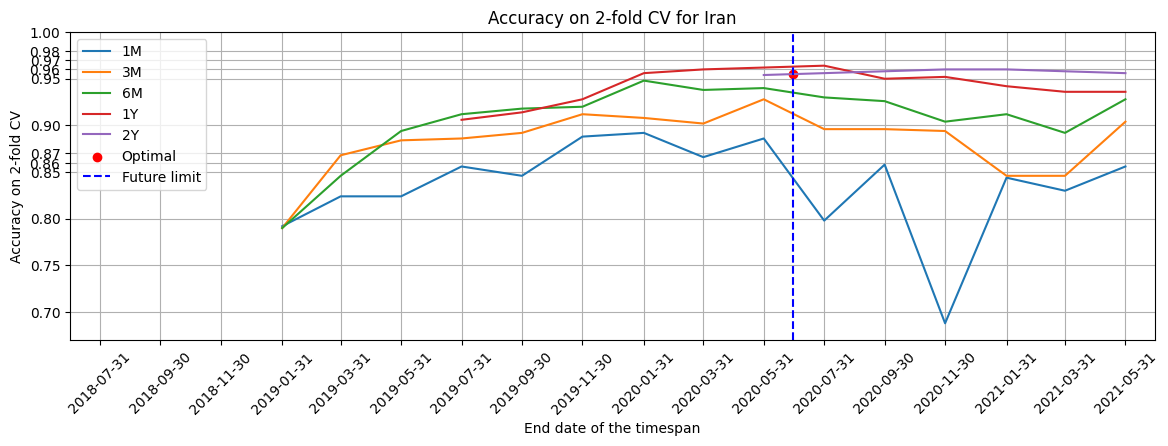

In [39]:
# Display results
optimal_parameters = [
    ['2021-03-31', 0.965],
    ['2023-04-30', 0.865],
    ['2020-06-30', 0.955]
]

for country, accs_spans, end_dates_in_experiment_spans, optimal_parameter in zip(country_settings.values(), countries_accs, end_dates_in_experiment_countries, optimal_parameters):
    fig, ax = plt.subplots(figsize=(14, 4))

    for span, accs_end_dates, end_dates in zip(spans_friendly_unit, accs_spans, end_dates_in_experiment_spans):
        ax.plot(end_dates, accs_end_dates, label=span)
    
    optimal_date = pd.to_datetime(optimal_parameter[0]).normalize()
    optimal_acc = optimal_parameter[1]
    ax.scatter(optimal_date, optimal_acc, color='red', label='Optimal')

    true_start_date = pd.to_datetime(country[START_DATE]) - pd.Timedelta(days=365)
    true_end_date = pd.to_datetime(country[END_DATE]) + pd.Timedelta(days=365)
    end_dates = pd.date_range(
        start=true_start_date,
        end=true_end_date,
        freq='2M'
    )

    plt.title(f'Accuracy on 2-fold CV for {country[COUNTRY_NAME]}')
    plt.xlabel('End date of the timespan')
    plt.ylabel('Accuracy on 2-fold CV')
    plt.xticks(end_dates, rotation=45)
    plt.xlim(true_start_date, true_end_date)
    plt.yticks(list(np.arange(0.7, 1.01, 0.05)) + [0.86, 0.87, 0.96, 0.97, 0.98])
    plt.ylim(0.67, 1)
    
    ax.axvline(pd.to_datetime(country[END_DATE]), color='blue', linestyle='dashed', label='Future limit')
    ax.legend()
    
    plt.grid()
    plt.show()

From this experiments, we can see that the best results are obtained with longer timeranges with saturation at aound 1 year.
We can also see that Afghanistan has significantly worse results than the other countries with a max acc of ~0.87 compared to ~0.97.

The vertical blue dashed-line represents the time after which future data is required.
We can see that Afghanistan seems to benefit from future data while other countries don't.


Finally, we can choose optimal timeranges and timeperiods for each country, they are represented by the red dots on the graph.
We choose them visually based on accuracy and stability around the optimal timeperiod.

| Country | Timerange | Start | End | Acc |
| --- | --- | --- | --- | --- |
| Sudan | 2 years | 2019-05-29 | 2021-03-29 | 0.97 |
| Afghanistan | 2 years | 2021-06-27 | 2023-04-30 | 0.87 |
| Iran | 2 years | 2018-08-28 | 2020-06-30 | 0.96 |

In [8]:
country_settings_optimal = {
    SUDAN: {
        COUNTRY_NAME: SUDAN,
        START_DATE: '2019-05-29',
        END_DATE: '2021-03-31',
        BOUNDS: [[14.1, 33.1], [14.6, 33.6]]
    },
    AFGHANISTAN: {
        COUNTRY_NAME: AFGHANISTAN,
        START_DATE: '2021-06-27',
        END_DATE: '2023-04-30',
        BOUNDS: [[34.0, 70.2], [34.4, 70.8]]
    },
    IRAN: {
        COUNTRY_NAME: IRAN,
        START_DATE: '2018-08-28',
        END_DATE: '2020-06-30',
        BOUNDS: [[32.0, 48.1], [32.5, 48.6]]
    }
}

# 4. Study on the impact of the choice of Sentinel-2 bands

In this section we investigate which Sentinel-2 bands are the most useful.  
We train a RandomForest with the same parameters on different band combinations and compare the results.  
Using all bands is not necessarily the best option as this will increase training time and memory usage and might lead to overfitting.

In [23]:
bandssets = [
    [SCL],
    [B3, B8],
    [B3, B4, B8],
    [B2, B3, B4, B8],
    [NDVI], 
    [B2, B3, B4, B8, NDVI, SCL],
    [B2, B3, B4, B8, LON, LAT, NDVI, SCL],
    ALL_BANDS
]

for bands in bandssets:
    ds_ts = Dataset_training_ready.get_ts_data_from(
        ds, bands.copy(), PROJECT_NAME, country_settings=country_settings_optimal)
    model = Model(rf_builder_shallow, ds_ts, SEED)
    acc, acc_0, acc_1, _, _ = model.train_with_cv_one_rf_per_country(debug_level=0, n_splits=5)
    print(f'   Accuracy : {acc:.3f} with {bands}')
    

   Accuracy : 0.901 with ['SCL']
   Accuracy : 0.935 with ['B3', 'B8']
   Accuracy : 0.937 with ['B3', 'B4', 'B8']
   Accuracy : 0.932 with ['B2', 'B3', 'B4', 'B8']
   Accuracy : 0.933 with ['NDVI']
   Accuracy : 0.939 with ['B2', 'B3', 'B4', 'B8', 'NDVI', 'SCL']
   Accuracy : 0.933 with ['B2', 'B3', 'B4', 'B8', 'Lon', 'Lat', 'NDVI', 'SCL']
   Accuracy : 0.935 with ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL', 'NDVI']


We can see that even with only the NDVI band, we can achieve a high cross-validation accuracy of ~0.93.  
For the final submission, we choose [B2, B3, B4, B8, Lon, Lat, NDVI, SCL].  
We've decided to keep Lon, Lat and SCL despite no significant accuracy improvment as they provide information different in nature than radiometric bands and might be useful to the model.

# 5. Reproduction of the submitted solution

In [1]:
##### PLEASE SET THIS VARIABLE TO YOUR PROJECT NAME IN GEE #####
PROJECT_NAME = "ee-antoinesaget"

In [2]:
# Imports and seeds initializations
import random
import ee

import numpy as np
import pandas as pd

from dataset import Dataset, Dataset_training_ready
from model import Model, rf_builder_shallow
from constants import SUDAN, AFGHANISTAN, IRAN, COUNTRY_NAME, START_DATE, END_DATE, BOUNDS, TARGET, B2, B3, B4, B8, LON, LAT, NDVI, SCL
from utils import save_submission

# Set seeds for reproducibility
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# Authenticate and initialize Earth Engine
# ee.Authenticate()
ee.Initialize()

In [4]:
# Country bounds and timeranges
country_settings = {
   SUDAN: {
        COUNTRY_NAME: SUDAN,
        START_DATE: '2019-07-01',
        END_DATE: '2020-06-30',
        BOUNDS: [[14.1, 33.1], [14.6, 33.6]]
    },
    AFGHANISTAN: {
        COUNTRY_NAME: AFGHANISTAN,
        START_DATE: '2022-04-01',
        END_DATE: '2022-04-30',
        BOUNDS: [[34.0, 70.2], [34.4, 70.8]]
    },
    IRAN: {
        COUNTRY_NAME: IRAN,
        START_DATE: '2019-07-01',
        END_DATE: '2020-06-30',
        BOUNDS: [[32.0, 48.1], [32.5, 48.6]]
    }
}

In [5]:
ds = Dataset.from_files('Train.csv', 'Test.csv', 'Full dataset', country_settings, debug_level=0)
# With pandas==2.1.1 there might be a warning about the column type, it can be ignored
# as it is fixed in next versions of pandas : https://github.com/pandas-dev/pandas/issues/55025

/home/antoine/zindi/geo_ai_cropland_mapping_submission/dataset.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Sudan' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[mask, COUNTRY] = country[COUNTRY_NAME]


In [8]:
# Please see 4. for more informations on bands choices
bands = [B2, B3, B4, B8, LON, LAT, NDVI, SCL]

# Please see 3. for more informations on timespans choices
country_settings_optimal = {
    SUDAN: {
        COUNTRY_NAME: SUDAN,
        START_DATE: '2019-05-29',
        END_DATE: '2021-03-31',
        BOUNDS: [[14.1, 33.1], [14.6, 33.6]]
    },
    AFGHANISTAN: {
        COUNTRY_NAME: AFGHANISTAN,
        START_DATE: '2021-06-27',
        END_DATE: '2023-04-30',
        BOUNDS: [[34.0, 70.2], [34.4, 70.8]]
    },
    IRAN: {
        COUNTRY_NAME: IRAN,
        START_DATE: '2018-08-28',
        END_DATE: '2020-06-30',
        BOUNDS: [[32.0, 48.1], [32.5, 48.6]]
    }
}

# Loading optical data
ds_ts = Dataset_training_ready.get_ts_data_from(
    ds, bands, PROJECT_NAME, country_settings=country_settings_optimal)

# Training and predicting
# Our final model is a single shallow random forest (per country) of 100 trees and a max depth of 10.
model = Model(rf_builder_shallow, ds_ts, SEED)
model.train_on_full_dataset_one_per_country()
preds, ids = model.predict_on_test()

# Check diff between original submission and current predisions
original = pd.read_csv('submissions/original_challenge_submission.csv', index_col='ID', usecols=['ID', TARGET])
original[TARGET] = original[TARGET].astype('uint8')

diff = original.loc[ids, TARGET] - preds
diff = diff[diff != 0] # True on rows different from original submission, False otherwise
print(f'Number of predictions different from original submission : {len(diff)}')

Number of predictions different from original submission : 0


In [9]:
save_submission(preds, ids, 'reproduction_of_original_submission')
# Please note that a diff with the original submission and this one will not be 0.
# By mistake, the original submission also included predictions of the training set.
# This mean that the original submission is 3000 rows while this one is 1500 rows (only test set)
# But the predictions on the test set are the same as shown in the above cell.